# NGCC HRSG Subflowsheet

To reduce the complexity of the NGCC model it is brocken into three parts 1) gas turbine, 2) heat recovery steam generator, and 3) steam turbine.  This notebook demonstrates running and getting results for teh HRSG section.

The HRSG model is sized for an NGCC that produces approximatly 650 MWe net when carbon capture is included. 

# Import Needed Modules

In [1]:
import os
from IPython.core.display import SVG
import pyomo.environ as pyo
import idaes
import idaes.core.util.scaling as iscale
from idaes.core.solvers import use_idaes_solver_configuration_defaults
from idaes.core.util.model_statistics import degrees_of_freedom
import hrsg

## Use the IDAES solver config 

Tell any solver that are created here on to use IDAES configuration and set the ipopt scaling method to 'user scaling' to pick up the variable scale factors.  

In [2]:
use_idaes_solver_configuration_defaults()
idaes.cfg.ipopt.options.nlp_scaling_method = "user-scaling"
idaes.cfg.ipopt.options.ma27_pivtol = 1e-2

## Create an initialize the model

This gets the flowsheet set up with input that should be consitent with the 650 MWe NGCC with carbon capture.  This also runs the initialization routine to populate variables with values that should make the model solvable.

In [3]:
# Create and initialize the HRSG flowsheet, is hrsg_init.json.gz exists
# load previous initialization to save time.
m = pyo.ConcreteModel()
m.fs = hrsg.HrsgFlowsheet(name="HRSG", default={"dynamic": False})
iscale.calculate_scaling_factors(m)
m.fs.initialize(load_from=None)
assert degrees_of_freedom(m) == 0
#strip_bounds = pyo.TransformationFactory("contrib.strip_var_bounds")
#strip_bounds.apply_to(m, reversible=False)

2022-03-02 22:46:49 [INFO] idaes.init.fs.econ_lp.tube: Initialization Complete
2022-03-02 22:46:50 [INFO] idaes.init.fs.econ_lp.shell.properties_in: Initialisation Complete, optimal - Optimal Solution Found.
2022-03-02 22:46:50 [INFO] idaes.init.fs.econ_lp.shell.properties_out: Initialisation Complete, optimal - Optimal Solution Found.
2022-03-02 22:46:50 [INFO] idaes.init.fs.econ_lp.shell.properties_out: fs.econ_lp.shell.properties_out State Released.
2022-03-02 22:46:50 [INFO] idaes.init.fs.econ_lp.shell: Initialization Complete
2022-03-02 22:46:50 [INFO] idaes.init.fs.econ_lp: fs.econ_lp Initialisation Step 1 Complete.
2022-03-02 22:46:50 [INFO] idaes.init.fs.econ_lp.shell.properties_in: fs.econ_lp.shell.properties_in State Released.
2022-03-02 22:46:50 [INFO] idaes.init.fs.econ_lp: fs.econ_lp Initialisation Complete.
2022-03-02 22:46:51 [INFO] idaes.init.fs.mixer1: Initialization Complete: optimal - Optimal Solution Found
2022-03-02 22:46:51 [INFO] idaes.init.fs.evap_lp.shell.prope

In [4]:
jac, nlp = iscale.get_jacobian(m, scaled=True)
print("Extreme Jacobian entries:")
for i in iscale.extreme_jacobian_entries(jac=jac, nlp=nlp, large=1000, small=0):
    print(f"    {i[0]:.2e}, [{i[1]}, {i[2]}]")
#print("Unscaled constraints:")
#for c in iscale.unscaled_constraints_generator(m):
#    print(f"    {c}")
#print("Scaled constraints by factor:")
#for c, s in iscale.constraints_with_scale_factor_generator(m):
#    print(f"    {c}, {s}")
print("Badly scaled variables:")
for v, sv in iscale.badly_scaled_var_generator(m, large=1e2, small=1e-4, zero=1e-10):
    print(f"    {v} -- {sv} -- {iscale.get_scaling_factor(v)}")
print(f"Jacobian Condition Number: {iscale.jacobian_cond(jac=jac):.2e}")

Extreme Jacobian entries:
Badly scaled variables:
    fs.econ_ip2.v_shell[0.0] -- 107.67486108699589 -- None
    fs.sh_ip1.v_shell[0.0] -- 155.54114087051 -- None
Jacobian Condition Number: 1.47e+09


In [5]:
m.fs.obj = pyo.Objective(
    expr=(
        (m.fs.sh_hp4.tube.properties_out[0].flow_mass - 133)**2 +
        (m.fs.sh_ip3.tube.properties_out[0].flow_mass - 155)**2 +
        (m.fs.sh_lp.tube.properties_out[0].flow_mass - 21)**2 +
        (m.fs.sh_hp4.tube.properties_out[0].temperature - 858)**2 +
        (m.fs.sh_ip3.tube.properties_out[0].temperature - 855)**2
        #(m.fs.sh_lp.tube.properties_out[0].temperature - 554)**2
    )
)
m.fs.evap_hp.hp_sat_vap_eqn.activate()

In [6]:
m.fs.evap_hp.area.unfix()
m.fs.evap_hp.area.setlb(10000)
m.fs.evap_hp.area.setub(16000)
m.fs.evap_ip.area.unfix()
m.fs.evap_ip.area.setlb(9000)
m.fs.evap_ip.area.setub(13000)
m.fs.evap_lp.area.unfix()
m.fs.evap_lp.area.setlb(7000)
m.fs.evap_lp.area.setub(13000)
m.fs.evap_lp.area.setlb(7000)
m.fs.evap_lp.area.setub(13000)
m.fs.split_fg_lp.split_fraction[0, "toLP_SH"].unfix()
m.fs.split_fg_lp.split_fraction[0, "toLP_SH"].setlb(0.3)
m.fs.split_fg_lp.split_fraction[0, "toLP_SH"].setub(0.7)

m.fs.sh_hp4.fcorrection_htc.unfix()
m.fs.sh_hp4.fcorrection_htc.setlb(0.6)
m.fs.sh_hp4.fcorrection_htc.setub(1.1)

m.fs.sh_ip3.fcorrection_htc.unfix()
m.fs.sh_ip3.fcorrection_htc.setlb(0.7)
m.fs.sh_ip3.fcorrection_htc.setub(1.4)

In [7]:
solver = pyo.SolverFactory("ipopt")
res = solver.solve(m, tee=True, symbolic_solver_labels=True)

Ipopt 3.13.2: nlp_scaling_method=user-scaling
tol=1e-06
ma27_pivtol=0.01


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes 

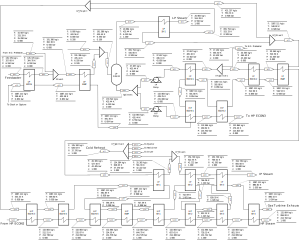

In [8]:
display(SVG(m.fs.write_pfd()))

In [9]:
m.fs.evap_hp.area.display()
m.fs.evap_ip.area.display()
m.fs.evap_lp.area.display()
m.fs.split_fg_lp.split_fraction.display()
m.fs.sh_hp4.fcorrection_htc.display()
m.fs.sh_ip3.fcorrection_htc.display()

area : Heat exchange area
    Size=1, Index=None, Units=m**2
    Key  : Lower : Value              : Upper : Fixed : Stale : Domain
    None : 10000 : 13158.602668875747 : 16000 : False : False : PositiveReals
area : Heat exchange area
    Size=1, Index=None, Units=m**2
    Key  : Lower : Value              : Upper : Fixed : Stale : Domain
    None :  9000 : 12540.466516601262 : 13000 : False : False : PositiveReals
area : Heat exchange area
    Size=1, Index=None, Units=m**2
    Key  : Lower : Value              : Upper : Fixed : Stale : Domain
    None :  7000 : 10065.928308864512 : 13000 : False : False : PositiveReals
split_fraction : Outlet split fractions
    Size=2, Index=fs.split_fg_lp.split_fraction_index
    Key              : Lower : Value               : Upper : Fixed : Stale : Domain
    (0.0, 'toLP_SH') :   0.3 :   0.603208268673672 :   0.7 : False : False :  Reals
    (0.0, 'toMixer') :  None : 0.39679173132632795 :  None : False : False :  Reals
fcorrection_htc : Correc